# Points

Otro dataset simple, pero que puede tener mas condiciones: imagenes 4x4 con 0,1,2,3 puntos, sin importar la posicion, conseguir pedirle imagenes con un numero de puntos determinados

In [25]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import random
import iqpopt as iqp
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic
import jax
import jax.numpy as jnp

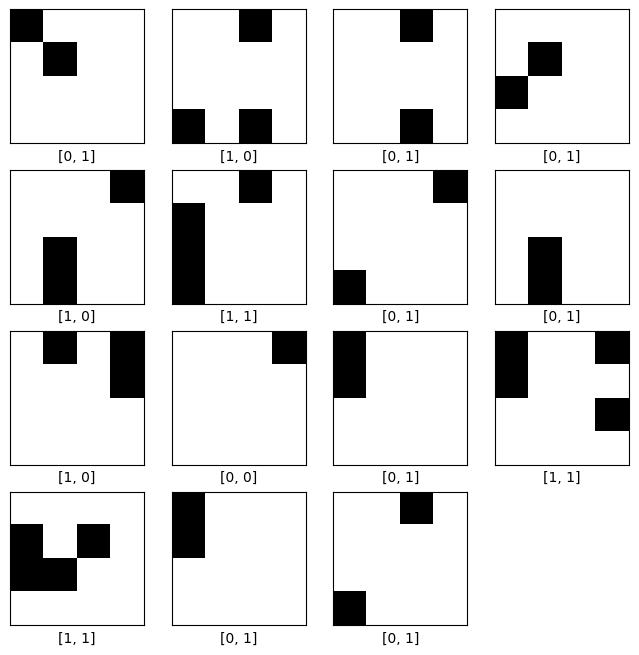

In [59]:
# Dataset

def point_images(size):
    num = np.random.choice([1,2,3,4])
    pattern = np.zeros((size,size))
    positions = np.linspace(0,size-1,size).astype(int).tolist()
    used = []
    labels = [[0,0],[0,1],[1,0],[1,1]]
    for k in range(num):
        while True:
            a,b = np.random.choice(positions),np.random.choice(positions)
            if [a,b] not in used:
                pattern[a,b] = 1
                used.append([a,b])
                break
    return labels[num-1] + np.concatenate(pattern).astype(int).tolist()

images = []
for k in range(20000):
    pattern = point_images(4)
    images.append(pattern)
    


j = 1
plt.figure(figsize=[8, 8])
for i in images[0:15]:
    im = i[2:]
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(im, [4, 4]), cmap="gray_r")
    plt.xlabel(i[0:2])
    plt.xticks([])
    plt.yticks([])



In [62]:
gates = []
#qbit 0 es el qbit de decision
n_qubits = 18
depth = 12

for d in range(depth):
    for k in range(n_qubits-2):
        gates.append([[k+2]])
        gates.append([[0,k+2]])
        gates.append([[1,k+2]])


circ = iqp.IqpSimulator(n_qubits,gates,device ='lightning.qubit')

2.7950849718747373


Training Progress: 100%|██████████| 300/300 [02:37<00:00,  1.90it/s, loss=0.000757, elapsed time=0.38, total time=158] 


Training has not converged after 300 steps


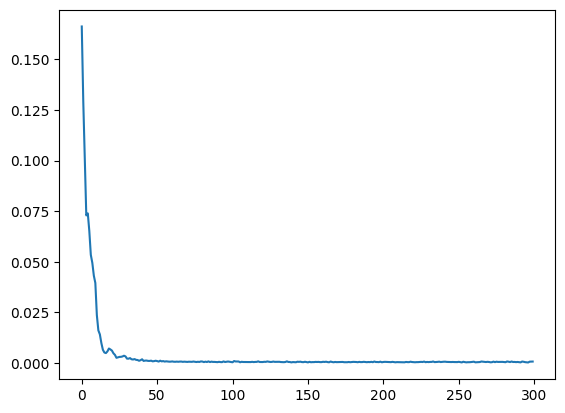

In [63]:
#Loss function
sigma = median_heuristic(images) * 1.25  #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)
#params_init = np.random.normal(0,1/np.sqrt(n_qubits), len(gates))
params_init = jax.random.normal(key, (len(gates),)) * (1 / jnp.sqrt(n_qubits))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": jnp.array(images), # samples from ground truth distribution
    "sigma": sigma,
    "n_ops": 2000,
    "n_samples": 2000,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.01)
trainer.train(n_iters= 300,loss_kwargs=loss_kwarg)
trained_params = trainer.final_params
plt.plot(trainer.losses)
plt.show() 

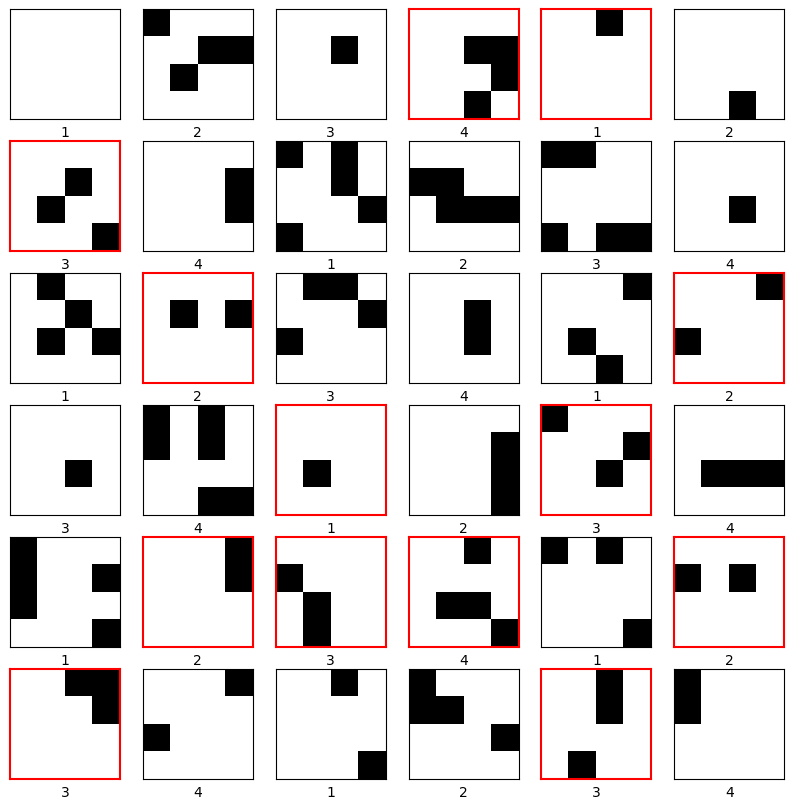

In [61]:
#Plots de resultados
j = 1
plt.figure(figsize=[10, 10])
for i in range(36):
    check = False
    if i % 4 == 0:
        res = iqp.IqpSimulator(n_qubits,gates,device ='lightning.qubit')
        sam = res.sample(trained_params,shots = 1)
        lab = 1
        im = sam[2:]
    
            
    elif i % 4 == 1:
        res = iqp.IqpSimulator(n_qubits,gates,init_gates=[[[1]]],init_coefs=[np.pi],device ='lightning.qubit')
        sam = res.sample(trained_params,shots = 1)
        lab = 2
        im = sam[2:]

    
    elif i % 4 == 2:
        res = iqp.IqpSimulator(n_qubits,gates,init_gates=[[[0]]],init_coefs=[np.pi],device ='lightning.qubit')
        sam = res.sample(trained_params,shots = 1)
        lab = 3
        im = sam[2:]
    elif i % 4 == 3:
        res = iqp.IqpSimulator(n_qubits,gates,init_gates=[[[0]],[[1]]],init_coefs=[np.pi, np.pi],device ='lightning.qubit')
        sam = res.sample(trained_params,shots = 1)
        lab = 4
        im = sam[2:]
        
    if sum(im) == lab:
        check = True
    ax = plt.subplot(6, 6, j)
    j += 1
    plt.imshow(np.reshape(im, [4, 4]), cmap="gray_r")
    if check == True:
        plt.setp(ax.spines.values(), color="red", linewidth=1.5)
    plt.xlabel(lab)
    plt.xticks([])
    plt.yticks([])